# Support files

Rename files

In [ ]:
import os

def rename_images(folder_path, prefix):
    # List all files in the folder
    files = sorted(os.listdir(folder_path))

    # Rename each file
    for i, file_name in enumerate(files):
        # Generate new name in the format: HC_001.png or PD_001.png
        new_name = f"{prefix}_{i+1:03d}.png"

        # Full paths
        old_path = os.path.join(folder_path, file_name)
        new_path = os.path.join(folder_path, new_name)

        # Rename the file
        os.rename(old_path, new_path)

    print(f"✅ Renaming Done for {prefix} folder!")

# Rename images in HC and PD folders
rename_images('/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/KCL_spectrogram/HC', 'HC')  # For Healthy Controls
rename_images('/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/KCL_spectrogram/PD', 'PD')  # For Parkinson's Disease


✅ Renaming Done for HC folder!
✅ Renaming Done for PD folder!


Updated feature dataset

In [ ]:
import pandas as pd
import os

# Load the tabular data
df = pd.read_csv('/content/MDVR KCL FEATURES.csv')

# Path to the spectrogram folders
hc_path = '/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/KCL_spectrogram/HC/'
pd_path = '/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/KCL_spectrogram/PD/'

# Assign spectrogram paths for first 120 rows (HC) and next 120 rows (PD)
df['Spectrogram_Path'] = [
    os.path.join(hc_path, f'HC_{i+1:03d}.png') if i < 450 else os.path.join(pd_path, f'PD_{i-449:03d}.png')
    for i in range(len(df))
]

# Save updated CSV
df.to_csv('Updated_KCL_Features.csv', index=False)

print("✅ Mapping Done Successfully!")


✅ Mapping Done Successfully!


# Main

Import libraries

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import cv2
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load data

In [ ]:

# Load the CSV Dataset
df = pd.read_csv('/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/Updated_KCL_Features.csv')

# Extract Features and Class Labels
X = df.iloc[:, 1:-2]  # Skip Spectrogram Path and Label
y = df['Class']

# Normalize the Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Select Best 30 Features Using Mutual Information
selector = SelectKBest(mutual_info_classif, k=30)
X_selected = selector.fit_transform(X_scaled, y)

# Split Dataset into Train-Test (80-20)
#X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)


Data preprocessing

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, csv_file, X_features, y_labels, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.X_features = X_features
        self.y_labels = y_labels
        self.transform = transform

    def __len__(self):
        return len(self.X_features)

    def __getitem__(self, idx):
        # Load spectrogram image
        image_path = self.dataframe['Spectrogram_Path'].iloc[idx]

        # Handling missing or corrupt images
        if not os.path.exists(image_path):
            print(f"❌ Warning: Missing spectrogram at {image_path}. Replacing with blank image.")
            image = np.zeros((224, 224, 3), dtype=np.uint8)  # Blank image
        else:
            image = cv2.imread(image_path)
            if image is None:
                print(f"❌ Warning: Corrupt image at {image_path}. Replacing with blank image.")
                image = np.zeros((224, 224, 3), dtype=np.uint8)  # Blank image
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transformations (e.g., resizing, normalization)
        if self.transform:
            image = self.transform(image)

        # Extract 30 selected features (from Mutual Information selection)
        tabular_features = torch.tensor(self.X_features[idx], dtype=torch.float32)

        # Extract label
        label = torch.tensor(self.y_labels.iloc[idx], dtype=torch.float32)

        return image, tabular_features, label

# Image Transformation for ResNet Model
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Load Dataset (Pass Reduced Features & Labels)
dataset = MultimodalDataset(csv_file="/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/Updated_KCL_Features.csv",
                            X_features=X_selected,
                            y_labels=y,
                            transform=transform)
# Train-Test Split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Define Model

In [ ]:

class MultimodalFusionModel(nn.Module):
    def __init__(self, num_tabular_features=30):
        super(MultimodalFusionModel, self).__init__()

        # 🎯 ResNet50 for Spectrogram Path
        resnet = models.resnet50(weights="IMAGENET1K_V2")
        self.resnet_feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer

        # 🔥 Fully Connected Network for Tabular Data
        self.tabular_fc = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # 🌟 Fusion Layer (Combines ResNet Features + Tabular)
        self.fusion_layer = nn.Sequential(
            nn.Linear(2048 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # Binary Classification (HC vs PD)
            nn.Sigmoid()  # Output Probability
        )

    def forward(self, image, tabular_data):
        # Extract Spectrogram Features
        image_features = self.resnet_feature_extractor(image)
        image_features = image_features.view(image_features.size(0), -1)  # Flatten

        # Extract Tabular Features
        tabular_features = self.tabular_fc(tabular_data)

        # 🔥 Fuse Both Modalities
        fused = torch.cat((image_features, tabular_features), dim=1)

        # 🎯 Final Classifier
        output = self.fusion_layer(fused)
        return output


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalFusionModel(num_tabular_features=30).to(device)

# Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Store Training History
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


Training & Validation

In [ ]:
# Training Loop
for epoch in range(15):  # Train for 20 Epochs
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, tabular_data, labels in train_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

        # Forward Pass
        outputs = model(images, tabular_data)
        loss = criterion(outputs, labels.unsqueeze(1))

        # Backward Pass & Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track Accuracy
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # 📌 Validation Loop
    model.eval()
    val_loss, val_acc = 0.0, 0
    correct, total = 0, 0

    with torch.no_grad():
        for images, tabular_data, labels in test_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels.unsqueeze(1))

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_acc = correct / total

    # Track History
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/20]: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/20]: Train Loss: 0.6842, Train Acc: 0.5556, Val Loss: 0.6668, Val Acc: 0.6333
Epoch [2/20]: Train Loss: 0.5017, Train Acc: 0.8819, Val Loss: 0.4540, Val Acc: 0.7500
Epoch [3/20]: Train Loss: 0.1742, Train Acc: 0.9708, Val Loss: 0.3173, Val Acc: 0.8611
Epoch [4/20]: Train Loss: 0.0511, Train Acc: 0.9889, Val Loss: 0.2256, Val Acc: 0.8944
Epoch [5/20]: Train Loss: 0.0271, Train Acc: 0.9917, Val Loss: 0.3869, Val Acc: 0.8500
Epoch [6/20]: Train Loss: 0.0187, Train Acc: 0.9958, Val Loss: 0.4217, Val Acc: 0.8500
Epoch [7/20]: Train Loss: 0.0329, Train Acc: 0.9903, Val Loss: 0.3303, Val Acc: 0.8611
Epoch [8/20]: Train Loss: 0.0148, Train Acc: 0.9958, Val Loss: 0.3505, Val Acc: 0.8778
Epoch [9/20]: Train Loss: 0.0065, Train Acc: 1.0000, Val Loss: 0.3034, Val Acc: 0.9111
Epoch [10/20]: Train Loss: 0.0027, Train Acc: 1.0000, Val Loss: 0.3022, Val Acc: 0.9111
Epoch [11/20]: Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.2962, Val Acc: 0.9167
Epoch [12/20]: Train Loss: 0.0016, Train 

In [ ]:
# ✅ Save Model Weights
torch.save(model.state_dict(), "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/ensemble_model2.pth")
print("✅ Model training completed and saved successfully!")

✅ Model training completed and saved successfully!


Load model (Optional)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/ensemble_model2.pth'))


<All keys matched successfully>

Evaluation

🔥 Classification Report:
              precision    recall  f1-score   support

          HC       0.87      0.64      0.74        84
          PD       0.75      0.92      0.82        96

    accuracy                           0.79       180
   macro avg       0.81      0.78      0.78       180
weighted avg       0.80      0.79      0.78       180



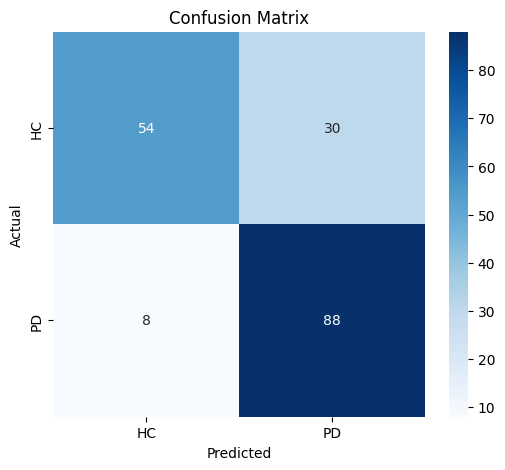

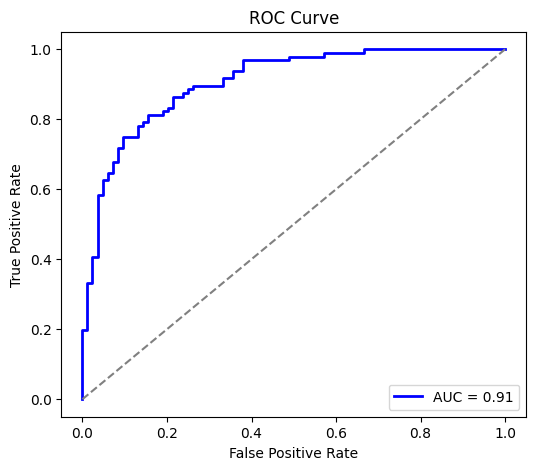

🔥 AUC-ROC Score: 0.9067


In [ ]:

model.eval()

all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

        outputs = model(images, tabular_data)
        probabilities = outputs.squeeze().cpu().numpy()
        predictions = (outputs > 0.5).float().cpu().numpy()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions)
        all_probs.extend(probabilities)
print("🔥 Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['HC', 'PD']))
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

print(f"🔥 AUC-ROC Score: {roc_auc:.4f}")


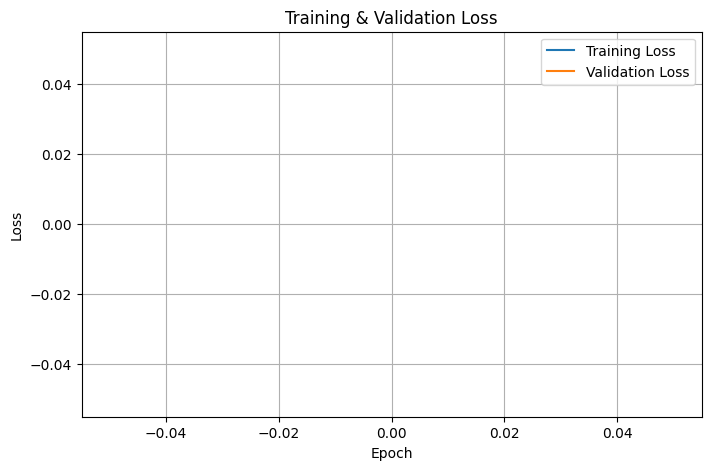

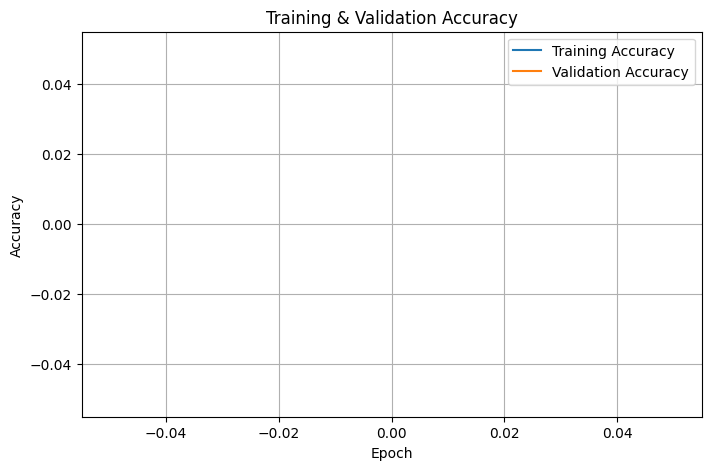

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Evaluate Spectrogram-Only Performance

In [ ]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, _, labels in test_loader:  # Only pass spectrogram data
        images = images.to(device)
        tabular_data = torch.zeros((images.size(0), 30)).to(device)  # Pass zero tabular features
        labels = labels.to(device)

        outputs = model(images, tabular_data)
        predictions = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

print("🔥 Performance Using Only Spectrograms:")
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))


🔥 Performance Using Only Spectrograms:
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.71       100
         1.0       0.00      0.00      0.00        80

    accuracy                           0.56       180
   macro avg       0.28      0.50      0.36       180
weighted avg       0.31      0.56      0.40       180

Accuracy: 0.5555555555555556


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluate Tabular-Only Performance

In [ ]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for _, tabular_data, labels in test_loader:  # Only pass tabular data
        tabular_data = tabular_data.to(device)
        images = torch.zeros((tabular_data.size(0), 3, 224, 224)).to(device)  # Pass blank images
        labels = labels.to(device)

        outputs = model(images, tabular_data)
        predictions = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

print("\n🔥 Performance Using Only Tabular Data:")
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))



🔥 Performance Using Only Tabular Data:
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.71       100
         1.0       0.00      0.00      0.00        80

    accuracy                           0.56       180
   macro avg       0.28      0.50      0.36       180
weighted avg       0.31      0.56      0.40       180

Accuracy: 0.5555555555555556


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# GRAD CAM

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register forward and backward hooks
        self.target_layer.register_forward_hook(self._save_activations)
        self.target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        # Forward pass
        self.model.eval()
        outputs = self.model(input_tensor, torch.zeros(1, 30).to(device))  # Dummy tabular input

        # Choose the class index with highest probability
        if class_idx is None:
            class_idx = outputs.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        outputs[0, class_idx].backward()

        # Grad-CAM Calculation
        gradients = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()

        weights = np.mean(gradients, axis=(2, 3))  # Global average pooling
        cam = np.zeros(activations.shape[2:], dtype=np.float32)

        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = np.maximum(cam, 0)  # ReLU
        cam = cv2.resize(cam, (224, 224))  # Resize to match input
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)  # Normalize to [0,1]
        return cam


In [ ]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to 3 channels for ResNet
    img = cv2.resize(img, (224, 224))
    img_pil = Image.fromarray(img)

    return transform(img_pil).unsqueeze(0)  # Add batch dimension


In [ ]:
def visualize_gradcam(model, image_path, target_layer):
    # Load and preprocess the spectrogram
    input_tensor = preprocess_image(image_path)

    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)

    # Generate Grad-CAM heatmap
    cam = gradcam.generate_cam(input_tensor)

    # Load original image for overlay
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (224, 224))

    # Convert heatmap to color
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay Grad-CAM on original spectrogram
    overlayed_image = (0.5 * heatmap + 0.5 * cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)).astype(np.uint8)

    # Display Results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Spectrogram")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    plt.title("Overlayed Grad-CAM")

    plt.show()


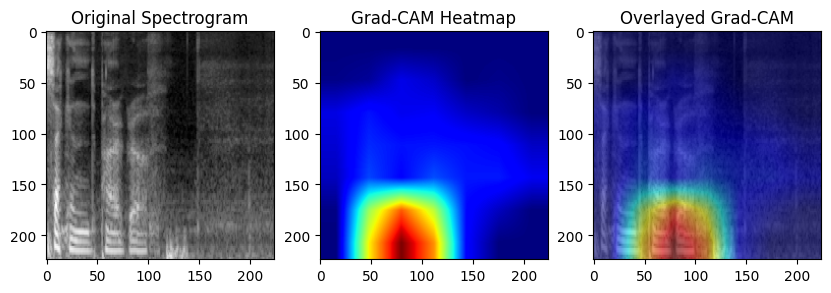

In [ ]:
# Choose the last convolutional layer in ResNet50
target_layer = model.resnet_feature_extractor[7][2].conv3   # Last conv layer in ResNet-50

# Path to the spectrogram image
spectrogram_image_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/KCL_spectrogram/PD/PD_009.png"

# Run Grad-CAM
visualize_gradcam(model, spectrogram_image_path, target_layer)


# Fine tuning

In [ ]:
# Freeze the initial layers of CNN (Spectrogram branch)
for param in model.resnet_feature_extractor.parameters():  # Changed to resnet_feature_extractor
    param.requires_grad = False

# Freeze the first few layers of Tabular branch (MLP network)
for param in model.tabular_fc[:2].parameters():  # Changed to tabular_fc
    param.requires_grad = False

# Unfreeze the final layers for fine-tuning
for param in model.resnet_feature_extractor[-2:].parameters():  # Changed to resnet_feature_extractor
    param.requires_grad = True

for param in model.tabular_fc[2:].parameters():  # Changed to tabular_fc
    param.requires_grad = True

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Loss Function
criterion = nn.BCELoss()

In [ ]:
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, tabular, labels in train_loader:
        images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)

        # Forward Pass
        outputs = model(images, tabular)
        loss = criterion(torch.sigmoid(outputs), labels.unsqueeze(1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")



Epoch 1/15, Loss: 0.7155989253002665
Epoch 2/15, Loss: 0.6209135755248691
Epoch 3/15, Loss: 0.5625272393226624
Epoch 4/15, Loss: 0.5290471354256505
Epoch 5/15, Loss: 0.5162476314150769
Epoch 6/15, Loss: 0.5118986173816349
Epoch 7/15, Loss: 0.5118534487226735
Epoch 8/15, Loss: 0.5113198562808658
Epoch 9/15, Loss: 0.5098201619542163
Epoch 10/15, Loss: 0.5094023580136506
Epoch 11/15, Loss: 0.5073829915212549
Epoch 12/15, Loss: 0.5079099989455679
Epoch 13/15, Loss: 0.5084554034730663
Epoch 14/15, Loss: 0.5098024995430656
Epoch 15/15, Loss: 0.5080846586953038


In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, tabular, labels in test_loader:
        images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)

        outputs = model(images, tabular)
        predictions = torch.round(torch.sigmoid(outputs))

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Cross-Validation

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
'''
# Load Pretrained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalFusionModel(num_tabular_features=30).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/ensemble_model2.pth'))
'''
model.eval()  # Set to evaluation mode

# Freeze All Model Layers
for param in model.parameters():
    param.requires_grad = False

# Define K-Fold Cross Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store results
accuracies, precisions, recalls, f1_scores, auc_rocs = [], [], [], [], []

# Perform Cross-Validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X_selected)):
    print(f"\n🚀 Evaluating Fold {fold+1}/{k_folds}")

    # Create Test Dataset for This Fold
    test_dataset = MultimodalDataset(
        csv_file="/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/Updated_KCL_Features.csv",
        X_features=X_selected[test_idx],
        y_labels=y.iloc[test_idx].reset_index(drop=True),
        transform=transform
    )

    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

    # Evaluation
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, tabular_data, labels in test_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device)

            outputs = model(images, tabular_data).squeeze()
            preds = (outputs >= 0.5).float()  # Convert probabilities to binary predictions

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute Metrics for This Fold
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    print(f"✅ Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f} | AUC-ROC: {auc:.4f}")

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    auc_rocs.append(auc)
    # Debug: Print raw model outputs and predictions
    print(f"Raw outputs: {outputs[:10].cpu().numpy()}")  # First 10 model outputs
    print(f"Predictions: {preds[:10].cpu().numpy()}")  # First 10 predictions
    print(f"True Labels: {labels[:10].cpu().numpy()}")  # First 10 actual labels

# Print Overall Performance
print("\n📊 **Final Cross-Validation Results**")
print(f"✅ Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"✅ Mean Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"✅ Mean Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"✅ Mean F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"✅ Mean AUC-ROC: {np.mean(auc_rocs):.4f} ± {np.std(auc_rocs):.4f}")



🚀 Evaluating Fold 1/5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Accuracy: 0.5167 | Precision: 0.0000 | Recall: 0.0000 | F1-Score: 0.0000 | AUC-ROC: 0.4947
Raw outputs: [5.7956040e-05 6.6879787e-05 4.8986339e-04 8.7985369e-05 6.6821136e-05
 2.9126781e-03 1.2472898e-04 2.6159516e-05 5.3929769e-05 4.6964331e-07]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True Labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

🚀 Evaluating Fold 2/5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Accuracy: 0.5333 | Precision: 0.0000 | Recall: 0.0000 | F1-Score: 0.0000 | AUC-ROC: 0.4948
Raw outputs: [5.8730388e-05 6.5695531e-05 4.8993417e-04 8.7465705e-05 6.6512228e-05
 2.9556688e-03 1.2391126e-04 2.6141159e-05 5.4210675e-05 4.7012767e-07]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True Labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

🚀 Evaluating Fold 3/5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Accuracy: 0.5222 | Precision: 0.0000 | Recall: 0.0000 | F1-Score: 0.0000 | AUC-ROC: 0.4947
Raw outputs: [5.8309721e-05 6.6489716e-05 4.8799202e-04 8.8225148e-05 6.6946275e-05
 2.9261948e-03 1.2623266e-04 2.5931524e-05 5.3545838e-05 4.6460445e-07]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True Labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

🚀 Evaluating Fold 4/5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Accuracy: 0.4333 | Precision: 0.0000 | Recall: 0.0000 | F1-Score: 0.0000 | AUC-ROC: 0.4937
Raw outputs: [5.8990157e-05 6.6954257e-05 4.9017940e-04 8.7790264e-05 6.6874301e-05
 2.9260486e-03 1.2490990e-04 2.5970850e-05 5.3695763e-05 4.6630100e-07]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True Labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

🚀 Evaluating Fold 5/5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Accuracy: 0.4667 | Precision: 0.0000 | Recall: 0.0000 | F1-Score: 0.0000 | AUC-ROC: 0.4941
Raw outputs: [5.8303329e-05 6.7096793e-05 4.8136379e-04 8.7678061e-05 6.6385561e-05
 2.9344284e-03 1.2522881e-04 2.6122369e-05 5.4056531e-05 4.6992554e-07]
Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True Labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

📊 **Final Cross-Validation Results**
✅ Mean Accuracy: 0.4944 ± 0.0382
✅ Mean Precision: 0.0000 ± 0.0000
✅ Mean Recall: 0.0000 ± 0.0000
✅ Mean F1-Score: 0.0000 ± 0.0000
✅ Mean AUC-ROC: 0.4944 ± 0.0004


In [ ]:
import pandas as pd
import cv2

# Load and check the shape of tabular data
df = pd.read_csv("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/Updated_KCL_Features.csv")  # Replace with your file name
print("Tabular Data Shape:", df.shape)  # (Rows, Columns)
print("Tabular Data Size:", df.size)    # Total number of elements

# Load and check the shape of the image
image = cv2.imread("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/KCL_spectrogram/PD/PD_009.png")  # Replace with your image file
if image is not None:
    print("Image Shape:", image.shape)  # (Height, Width, Channels)
    print("Image Size:", image.size)    # Total number of pixels (H x W x C)
else:
    print("Error loading image. Check the file path.")


Tabular Data Shape: (900, 146)
Tabular Data Size: 131400
Image Shape: (308, 775, 3)
Image Size: 716100
